# Basics of Zipline API for Trading

1) Creating Basic Framework of zipline code

2) Simulating trade with a simple example

### 1)

In [ ]:
#### Example framework of executing trade strategy
def initialize(context):
    # Pass initial informations regarding trade  into 'context' variable(global variable)
    # Exp: stock symbol, initial capital, ...etc or include them in the zipline algorithm as inputs
        
def handle_data(context, data):
    # Code execution of trade strategy (conditions to long, short asset [context.order()]), tech indicator used
    # Recording portfolio values at interval (cash value and asset hold value [context.record()])
    # For simplicity of example, there will be no shorting stock, only long stock only if there is sufficient cash

# Execute strategy with obtained asset data('panel' for example below) and other inputs
# Storing output in a variable 'perf'

per=TechnicalIndicator_Name().run(data)


### 2)

In [1]:
# package to extract stock data from alpha_vantage API
from alpha_vantage.timeseries import TimeSeries

# package to plot 
import matplotlib.pyplot as plt

# package to check and set directory
import os

# package to use pandas DataFrame or Pandas
import pandas as pd

# packages to execute excel spreadsheet conversion function
import openpyxl
import xlrd

# Required to set datetimes for zipline algorithm later
import pytz

In [2]:
# get current directory
os.getcwd()

'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1'

In [3]:
# set path as current directory
os.chdir('C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1')

In [4]:
# Execute functions with API keys
with open('ak.txt', 'r') as myFile:
    keys=myFile.read()
    ts=TimeSeries(key=keys, output_format='pandas')

In [5]:
# Extract data of interest('AAPL' stock this case)
symbol='AAPL'
columns=['open', 'volume', 'low', 'close', 'high']
#data0, meta_data0=ts.get_intraday(symbol='AAPL', interval='5min', outputsize='full')
data0, meta_data0=ts.get_daily(symbol='AAPL', outputsize='full')
data0.head()

,1. open,5. volume,4. close,2. high,3. low
date,,,,,
1999-12-29,96.81,2540200.0,100.69,102.19,95.50
1999-12-30,102.19,1849500.0,100.31,104.12,99.62
1999-12-31,100.94,1462600.0,102.81,102.87,99.50
2000-01-03,104.87,4783900.0,111.94,112.50,101.69
2000-01-04,108.25,4574800.0,102.50,110.62,101.19


In [6]:
# Rename column names in accordance with zipline algorithm column name
data0=data0.rename({"1. open": "open", "5. volume": "volume", "2. high": "high", "4. close": "close", "3. low":"low"}, axis='columns')
# Rearranging columns by OHLC format then volume
data0=data0[['open', 'high', 'low', 'close', 'volume']]
data0.head()

,open,high,low,close,volume
date,,,,,
1999-12-29,96.81,102.19,95.50,100.69,2540200.0
1999-12-30,102.19,104.12,99.62,100.31,1849500.0
1999-12-31,100.94,102.87,99.50,102.81,1462600.0
2000-01-03,104.87,112.50,101.69,111.94,4783900.0
2000-01-04,108.25,110.62,101.19,102.50,4574800.0


In [7]:
# Export Dataframe(d0) to excel spreadsheet to be extracted in excel format
from collections import OrderedDict

data = OrderedDict()

data_ex=data0.to_excel(r'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1\\csvdir\\daily\\aapl.xlsx')
data['AAPL']=pd.read_excel(r'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1\\csvdir\\daily\\aapl.xlsx', index_col='date')
print(data['AAPL'].tail())

              open    high       low   close    volume
date                                                  
2019-12-23  280.53  284.25  280.3735  284.00  24677883
2019-12-24  284.69  284.89  282.9197  284.27  12119714
2019-12-26  284.82  289.98  284.7000  289.91  23334004
2019-12-27  291.12  293.97  288.1200  289.80  36592936
2019-12-30  289.46  292.69  285.2200  291.52  35771563


In [8]:
# minor_axis being axis 1, major_axis being axis 2
# localizing date by utc timezone for major_axis
# axis 1 consisting of stock name 'AAPL'
# axis 2 consisting of 5 column names (close, high, open, low, volume)
# axis 3 consisting of all datas of the 5 column names for each date
panel = pd.Panel(data)
panel.minor_axis = columns
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 5033 (major_axis) x 5 (minor_axis)
Items axis: AAPL to AAPL
Major_axis axis: 1999-12-29 00:00:00+00:00 to 2019-12-30 00:00:00+00:00
Minor_axis axis: open to high


In [9]:
from zipline.api import order, record, symbol, set_benchmark
import zipline
from datetime import datetime

def initialize(context):
    # adds Series data formatting to results for algorithm performance comparison with benchmark('AAPL')
    set_benchmark(symbol("AAPL"))

def handle_data(context, data):
    # Example strategy
    # Order 10 AAPL stocks everyday as long as there is still enough cash(initial capital-stock hold value)
    # Record all data (some are self generated from algorithm, shown below in Out[17])
    order(symbol("AAPL"), 10)
    record(AAPL=data.current(symbol('AAPL'), 'price'))

# Run zipline algorithm with necessary inputs like time period, 
# initialize(def), handle_data(def), capiatl, and data(panel)
perf = zipline.run_algorithm(start=datetime(1999, 12, 29, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2019, 12, 29, 0, 0, 0, 0, pytz.utc),
                      capital_base=100000,
                      initialize=initialize,
                      handle_data=handle_data,
                      data=panel)

In [10]:
perf.head()
# zipline algoritm returns interesting outputs (volatiity, alpha value, beta value, ending_cash,...etc)

# ending_cash is the amount of capital(in cash) left at the end of the time period

# ending_cash remains the same for first day(29 Dec) :
# Althought order made on 29 Dec, trade only executed on start of next day
# therefore AAPL price below uses opening price instea of closing price

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
1999-12-29 21:00:00+00:00,100.69,NaN,0.000000,NaN,0.040079,NaN,NaN,0.00000,100000.00000,0.0,...,0.0,0.0,0,NaN,100000.00000,0.0,0.0,1,[],0.0
1999-12-30 21:00:00+00:00,100.31,0.000057,-0.000005,-0.001178,0.036153,0.492243,0.000117,-1003.61155,98996.38845,1003.1,...,0.0,0.0,0,-11.224972,100000.00000,0.0,0.0,2,"[{'price': 100.360155, 'dt': 1999-12-30 21:00:...",0.0
1999-12-31 18:00:00+00:00,102.81,0.002267,0.000240,0.013762,0.061977,0.353556,0.001238,-1028.62405,97967.76440,2056.2,...,0.0,0.0,0,429.358814,98996.38845,1003.1,1003.1,3,"[{'price': 102.861405, 'dt': 1999-12-31 18:00:...",0.0
2000-01-03 21:00:00+00:00,111.94,0.013934,0.002060,-0.060284,0.156286,0.614854,0.020105,-1119.96970,96847.79470,3358.2,...,0.0,0.0,0,3195.556792,97967.76440,2056.2,2056.2,4,"[{'price': 111.99597, 'dt': 2000-01-03 21:00:0...",0.0
2000-01-04 21:00:00+00:00,102.50,0.026645,-0.000777,-0.123150,0.058775,1.015730,0.025442,-1025.52250,95822.27220,4100.0,...,0.0,0.0,0,-1.935372,96847.79470,3358.2,3358.2,5,"[{'price': 102.55125, 'dt': 2000-01-04 21:00:0...",0.0


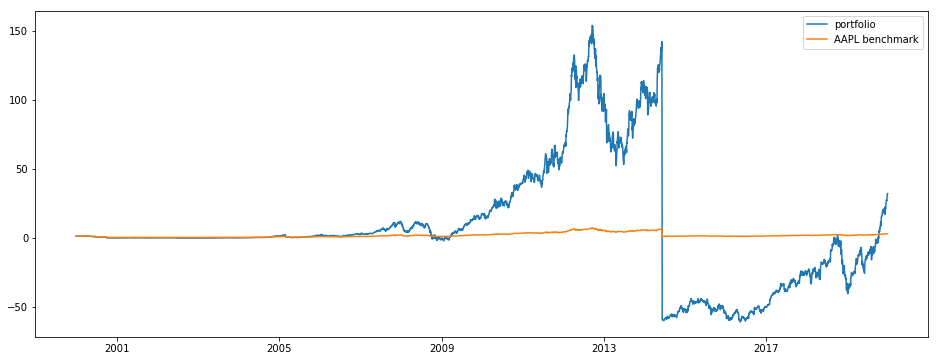

In [11]:
# Plotting AAPL benchmark and portfolio cumulative daily returns to understand trade strategy long term performance
plt.figure(figsize=(16,6))
portfolio_daily_ret=perf.portfolio_value.pct_change()
AAPL_daily_ret=perf.AAPL.pct_change()

plt.plot((1+portfolio_daily_ret).cumprod())
plt.plot((1+AAPL_daily_ret).cumprod())

plt.legend(('portfolio', 'AAPL benchmark'), loc=0)

plt.show()

# Conclusion of strategy:

-Strategy would work in early stages but fails around June 2014 due to sudden fall in Apple stock because:
 it issued more shares to existing investors in order to bring down the price of the stock(called stock split, 7-to-1)

-But since its the case of stock split, it would not affect equity of shareholder as having 100 stock bfr means having
 700 stocks after split, thus rendering above portfolio plot obsolete.

-Perhaps it is advisable to start another additional identical strategy from June 2014 onwards to prevent
 portfolio performance confusion